In [1]:
# POWER MODEL MAIN
# Created: 10/06/2022
# Author: Cameron King
# Function Authors: Henri Wessels, Alec Church

# Description:
#
# This is the main script that models the power collection, transmission, and receiving systems/processes.
# Generally takes in satellite design choices and varies altitude and transmission time to see what orbits/transmission
# times are possible with current choices, and which of those are most efficient. 
# These outputs of most efficient range of orbit/time, as well as sub-models made during the formation of this model, 
# will be given to other groups within the team to inform on their design decisions as well as ROI, mass, MOI, etc.


# libraries
import math
import numpy
import mpmath
import matplotlib.pyplot as plt

# functions
from ipynb.fs.full.efficiency_funcs import *
from ipynb.fs.full.transmission_funcs import *
from ipynb.fs.full.GaussNCone import *
from ipynb.fs.full.Current_Orbit_Values import *

In [2]:
# Step 1:
#
# power_collection_func (Henri), outputs Power available

# Inputs: Solar panel area, panel efficiency, storage efficiency, battery choices, IMPORTANT: Comms & other sat power usage

# no looping, just determines the power available for transmission given choices above. 
# Will need to be scaleable, to be able to vary total collected power (incase transmission losses are calculated to be too big, and we need more collected)

# outputs: P_C (Power collected), P_A (Power Available for transmission)


In [20]:
# Step 2:
#
# determines values for power_transmission_func
# defines constants and core variables h & t

#############################################################
######### THESE ARE THE ONLY THINGS YOU SHOULD VARY #########
#############################################################

# orbit
h = 100000; # Passover Altitude, m


# Battery Type
    # specs : https://www.nasa.gov/smallsat-institute/sst-soa/power --> table 3-7
    # Lithium ion -> Power Density: 1500 W/kg
    #                Gravimetric Energy: 100-265 Wh/kg
# battery power and energy density
P_per_kg = 1500 # W/kg
E_per_kg = 200 # Wh/kg
# battery mass
LI_battery_mass = 1000 # kg

# laser
laser_loss = 0.2 # percentage of loss of power in the laser itself
laser_intake_wattage = 100000 # must be less than P_per_kg*LI_battery_mass


# receiver and aperture
r = 10; # m, radius of the reciever
rec_zleff = 0.41 # receiver's zero loss efficiency (normal / maximum efficiency of flux power to elec power) 
rec_b_0 = 0.1 # reflectivity constant, 0.1 for 1 sheet of glass, 0.2 for 2
rec_I_cutoff = 1380*450 # W/m^2 Max flux receiver can withstand, any higher flux and this is the power accepted. This caps the flux allowed.

r_aperture = 0.25; # m, radius of output lens on sc


# attitude & position errors
pos_err = [0,0,0];
point_err = [0,0];

##################################################################
##################################################################
##################################################################



# Constants
mu_m = 4.905E12; # Gravitational parameter of the moon, 
r_m = 1737500; # radius of the moon, m




###### calculate max transmission time for current battery specs & receiver specs ######

# battery total power calculations
P_batt_avail = P_per_kg*LI_battery_mass # total power available with given mass of battery
E_batt_avail = E_per_kg*LI_battery_mass # total energy available with given mass of battery

# laser loss and maximum discharge time
L_W = laser_intake_wattage*(1-laser_loss) # Laser Wattage, this is the battery/capaciter AVERAGE watt output possible, minus the power loss of the laser
t_max_battery = E_batt_avail/laser_intake_wattage*3600; # max discharge time, equal to maximum transmission time for this battery

# receiver maximum trasnmission time given receiver efficiency, this takes time of total view into account
V = math.sqrt(mu_m/(r_m+h)); # orbital velocity, Orbit assumed circular for this value
theta_r_max = mpmath.acos(rec_b_0/(1+rec_b_0))
theta_s_max_receiver = mpmath.asin( r_m* mpmath.sin(numpy.pi-theta_r_max)/(r_m+h) )
alpha_max_receiver = theta_r_max-theta_s_max_receiver
t_max_receiver = 2*(r_m+h)*alpha_max_receiver/V

t_end = min([t_max_battery,t_max_receiver]) # choose the smallest maximum time possible with given orbit & battery 


##### Orbital Calculations of maximum/average values

# time step accuracy
t_step = t_end/1000; # size of time step, s
N = t_end/t_step; # number of elements in every model array ALWAYS USE THIS FOR LOOPS
N = int(N)

# preallocate
t = numpy.zeros(N);
d = numpy.zeros(N);
theta_s = numpy.zeros(N);
theta_r = numpy.zeros(N);
FOV = numpy.zeros(N);
r_prime = numpy.zeros(N);
dtheta_s = numpy.zeros(N);
dtheta_s_approx = numpy.zeros(N);
ddtheta_s_approx = numpy.zeros(N);
# loop through time period to figure out average distance and average size of the receiver
for i in range(0,N):
    t[i] = i*t_step; # calculate current time
    
    current_sich = Current_Orbit_Values(h,t_end,t[i],V,r)
    
    # split up the output from Current_Orbit_Values into useful values to save
    d[i] = current_sich[0]
    theta_s[i] = current_sich[1]
    theta_r[i] = current_sich[2]
    FOV[i] = current_sich[3]
    r_prime[i] = current_sich[4]
    
    # find pointing speed, approximatly
    if i == 0 :
        dtheta_s_approx[i] = 0
        ddtheta_s_approx[i] = 0
    else :
        dtheta_s_approx[i] = abs(theta_s[i] - theta_s[i-1])
        ddtheta_s_approx[i] = dtheta_s_approx[i] - dtheta_s_approx[i-1]
        
    
# calculate average distance and r_prime for part 3, and find focal length

d_ave = numpy.mean(d)
r_b = numpy.mean(r_prime)

alpha_ave = mpmath.atan((r_b-r_aperture)/d_ave) # ideal view angle, this is the defining angle of the shape of the beam
focal_length = -r_aperture/mpmath.tan(alpha_ave) # focal length of necessary diverging lens, neg cause diverging


In [21]:
# Step 3:
# Loop through power transmission function, determine flux dispersion, power transmitted, and power losses
# This assumes that warm up time for the laser is negligable, and the maximum wattage is always produced

# inputs from above: r_b, d_ave (conditions for beam focal distance and radius at focal point)

# preallocations
F_disp = [];
P_T = [];
UA_F_disp = [];
I_ave = numpy.zeros([N-1,100]);
I_max = numpy.zeros(N-1)
# loop through the transmission period on a path of altitude h over flat surface, determine the flux dispursion at each point
# the flux dispursion includes total power transmitted, the size of the beam at the receiver, and 'shells' which contain a percentage of the total flux each.
# this section also accounts for the max intensity, but also measures the UA = UNADJUSTED flux dispursion to determin soley position error down the line
for i in range(0,N-1):
    
    current_disp = gaussNcone_transmission_func(r_aperture,r_b,d_ave,d[i],L_W)
    current_disp = numpy.array(current_disp)
    
    # check if intensity of shell is above the maximum, adjust the percentage within to keep I_ave[shell] < rec_I_cutoff
    for j in range(1,len(current_disp[1,:])):
        P_perc_old = current_disp[1,j]
        A_shell = (numpy.pi*(current_disp[0,j]**2-current_disp[0,j-1]**2)) # area of the shell rn
        I_ave[i,j] = (current_disp[1,0]*current_disp[1,j])/A_shell # (total power * percent of power within shell) / area of shell

        if I_ave[i,j] >= rec_I_cutoff: # we need to reassign the second row of current_disp to rec_I_cutoff = P_within / A_shell
            P_allowed = rec_I_cutoff*A_shell
            P_perc_new = P_allowed/current_disp[1,0]
            current_disp[1,j] = P_perc_new
    
    I_max[i] = max(I_ave[i,:])  
    F_disp.append(current_disp) 
    P_T.append(current_disp[1,0])

F_disp = numpy.array(F_disp) # flux dispursion for each time step in a matrix
UA_F_disp = numpy.array(UA_F_disp) # this is the incident flux, unadjusted (UA) for the receiver's max intensity
        


In [22]:
### Step 4:
#
# Determining efficiencies and power received
# loops through the transmission period to determine actual amount of power received
# accounts for pointing and position errors, as well as losses due to incident angle and efficiency of the reciever

# preallocations
n_rec = numpy.zeros(N);
n_pos = numpy.zeros(N);
UA_n_pos = numpy.zeros(N);
E_R = numpy.zeros(N);
E_T = numpy.zeros(N);

for i in range(0,N-1):

    n_rec[i] = receiver_eff_func(theta_r[i], rec_zleff, rec_b_0);
    # this function calculates the efficiency associated with incidence angle and receiver efficiency
    # it will be between 0 & 1, where 1 is 100% efficient and 0 is 0%.
    # This efficiency includes the flux dispursion in the analysis
    
    UA_F_disp = gaussNcone_transmission_func(r_aperture,r_b,d_ave,d[i],L_W)
    UA_n_pos[i] = position_eff_func(theta_r[i], pos_err, point_err, UA_F_disp, h, r); 
    # this is the position error, without taking max intensity into account 
    
    n_pos[i] = position_eff_func(theta_r[i], pos_err, point_err, F_disp[i,:,:], h, r);
    # this function will determine the efficiency associated with the pointing and position error of the satellite
    # it will be between 0 & 1, where 1 is 100% efficient and 0 is 0%.
    # effiency = F_hit/F_beam (areas normalized to flux)
    # each 'shell' (r70,r90,r99) will include a certain amount of W, and the % of that shell that hits the receiver is the efficiency of that shell

    E_R[i] = t_step*P_T[i]*n_rec[i]*n_pos[i]
    E_T[i] = t_step*P_T[i]
    #print(n_pos[i])
        
E_R_tot = sum(E_R); # This is in Joules ->
E_R_tot = E_R_tot*2.77*10**-7 # kWh

E_T_tot = sum(E_T); # This is in Joules ->
E_T_tot = E_T_tot*2.77*10**-7 # kWh

print('Energy and Efficiency:')
print('  Energy Received is',round(E_R_tot,3),'Wh');
print('  Energy Transmitted is',round(E_T_tot,3),'Wh');
print('  Transmission Energy Efficiency',round(E_R_tot/E_T_tot*100,2),'%\n');

print('Maximum Transmission Times:')
print('  Total Transmission time is', round(t_end,2),'s')
print('    -Total time battery can transmit is', round(t_max_battery,2),'s')
print('    -Total time receiver can receive is', round(t_max_receiver,2),'s\n')

print('SC Attitude and Pointing Requirments:')
print('  The necessary focal length of this ideal lens is',round(focal_length/1000,2), 'km')
print('  The necessary maximum pointing speed is',round(max(dtheta_s_approx),5), 'rad\s')
print('  The necessary maximum poingint acceleration is',round(max(ddtheta_s_approx),5), 'rad\s^2')





Energy and Efficiency:
  Energy received is 1.908 Wh
  Energy Transmitted is 12.56 Wh
  Transmission Energy Efficiency 15.2 %

Maximum Transmission Times:
  Total Transmission time is 567.33 s
    -Total time battery can transmit is 7200.0 s
    -Total time receiver can receive is 567.33 s

SC Attitude and Pointing Requirments:
  The necessary focal length of this ideal lens is -15.69 km
  The necessary maximum pointing speed is 0.00876 rad\s
  The necessary maximum poingint acceleration is 0.00017 rad\s^2


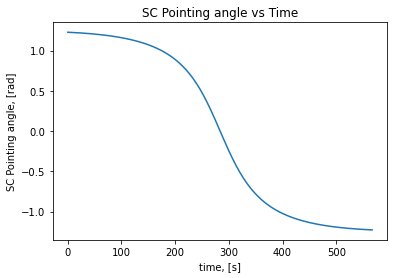

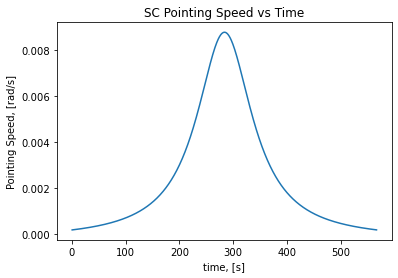

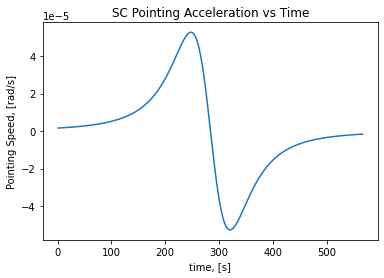

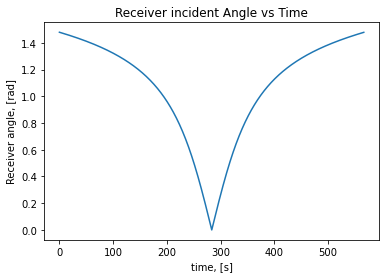

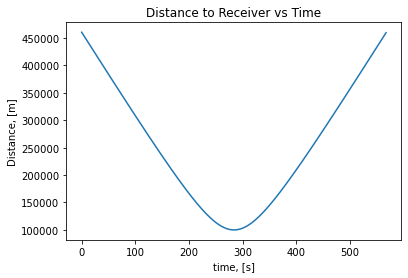

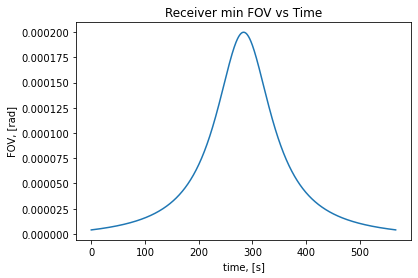

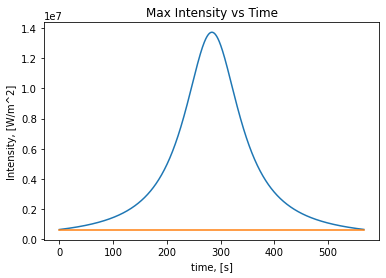

In [23]:
# plotting orbital parameters over transmission period

# sc angle
plt.figure()
plt.title('SC Pointing angle vs Time')
plt.plot(t,theta_s)
plt.xlabel('time, [s]');
plt.ylabel('SC Pointing angle, [rad]');

# Pointing Speed
plt.figure()
plt.title('SC Pointing Speed vs Time')
plt.plot(t[1:],dtheta_s_approx[1:])
plt.xlabel('time, [s]');
plt.ylabel('Pointing Speed, [rad/s]');

# Pointing Acceleration
plt.figure()
plt.title('SC Pointing Acceleration vs Time')
plt.plot(t[2:],ddtheta_s_approx[2:])
plt.xlabel('time, [s]');
plt.ylabel('Pointing Speed, [rad/s]');

# receiver angle
plt.figure()
plt.title('Receiver incident Angle vs Time')
plt.plot(t,theta_r)
plt.xlabel('time, [s]');
plt.ylabel('Receiver angle, [rad]');

# distance
plt.figure()
plt.title('Distance to Receiver vs Time')
plt.plot(t,d)
plt.xlabel('time, [s]');
plt.ylabel('Distance, [m]');

# FOV
plt.figure()
plt.title('Receiver min FOV vs Time')
plt.plot(t,FOV)
plt.xlabel('time, [s]');
plt.ylabel('FOV, [rad]');

# Max Intensity
plt.figure()
plt.title('Max Intensity vs Time')
plt.plot(t[:-1],I_max)
plt.plot(t[:-1],rec_I_cutoff*numpy.ones(len(t[:-1])))
plt.xlabel('time, [s]');
plt.ylabel('Intensity, [W/m^2]');

